## Competition Overview
Welcome to the IEEE-CIS Fraud Detection Competition, presented in collaboration with Vesta Corporation, a leading payment service company. In this competition, we invite you to tackle the challenging task of fraud prevention using advanced machine learning techniques. Leveraging Vesta's real-world e-commerce transaction dataset, you will have the opportunity to benchmark and develop innovative solutions for detecting fraudulent activities.

## Problem Statement
Fraud detection plays a critical role in safeguarding sensitive information, assets, accounts, and transactions. By employing real-time and near-real-time analysis of user activities and defined entities, fraud detection mechanisms identify anomalies and deviations from expected behavior. Through the utilization of background server-based processes, this competition aims to assess the efficacy of machine learning models in identifying fraudulent patterns within a large-scale dataset.

## Data Description
The dataset provided contains a comprehensive set of features, each offering valuable insights into transaction characteristics and identity attributes. Key attributes include:

TransactionDT: A timedelta from a reference datetime, representing the time of the transaction.

TransactionAMT: The payment amount for each transaction in USD.

ProductCD: A code representing the product associated with each transaction.

card1 - card6: Payment card information, including card type, category, issuer bank, and country.

addr1, addr2: Address details.

dist: Distance information.

P_ and R_emaildomain: Purchaser and recipient email domains.

C1-C14: Counting attributes, which are obfuscated in meaning.

D1-D15: Timedeltas representing days between previous transactions.

M1-M9: Match attributes, such as card and address names.

Vxxx: Engineered features with ranking, counting, and entity relations.

Additionally, the identity table provides network connection information and digital signatures associated with transactions. It includes attributes like DeviceType, DeviceInfo, and id_12 - id_38.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import HTML
%matplotlib inline
sns.set_style("whitegrid")

In [2]:
train_transaction = pd.read_csv("data/train_transaction.csv")
train_identity = pd.read_csv("data/train_identity.csv")
test_transaction = pd.read_csv("data/test_transaction.csv")
test_identity = pd.read_csv("data/test_identity.csv")

In [3]:
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
train_identity.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [5]:
train_df = train_transaction.merge(train_identity, how="left", on="TransactionID")

test_df = test_transaction.merge(test_identity, how="left", on="TransactionID")

In [6]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [7]:
train_df = reduce_mem_usage(train_df)
test_df  = reduce_mem_usage(test_df)

Mem. usage decreased to 650.48 Mb (66.8% reduction)
Mem. usage decreased to 565.37 Mb (66.3% reduction)


In [8]:
train_df.shape, test_df.shape

((590540, 434), (506691, 433))

In [9]:
print(train_df.isnull().sum())

TransactionID          0
isFraud                0
TransactionDT          0
TransactionAmt         0
ProductCD              0
                   ...  
id_36             449555
id_37             449555
id_38             449555
DeviceType        449730
DeviceInfo        471874
Length: 434, dtype: int64


In [10]:
print('Number of columns with missing values:')
train_df.isnull().any().sum()

Number of columns with missing values:


414

### Exploratory Data Analysis

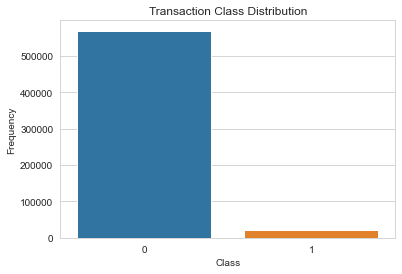

In [11]:
sns.countplot(x="isFraud", data=train_df)
plt.title("Transaction Class Distribution")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()

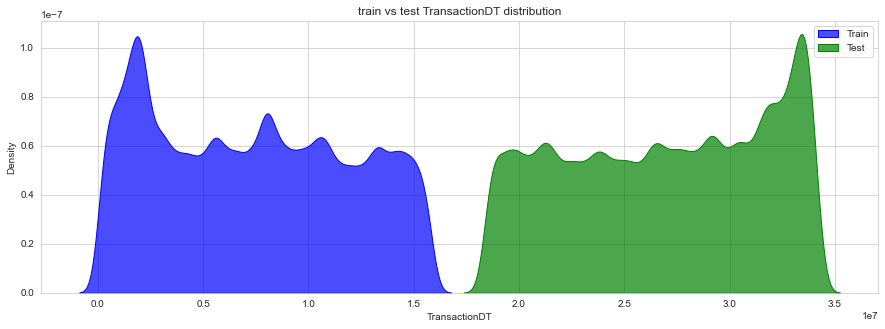

In [12]:
plt.figure(figsize=(15, 5))
sns.kdeplot(train_df["TransactionDT"], fill=True, color='blue', label='Train',  alpha=0.7)
sns.kdeplot(test_df["TransactionDT"], fill=True,  color='green', label='Test',  alpha=0.7)
plt.title('train vs test TransactionDT distribution')
plt.legend()
plt.show()


It seems that the dataset have been split into training and testing portions based on time. For example, the training data might contain transactions from an earlier period, while the testing data contains transactions from a later period.

In [13]:
train_fraud = train_df.loc[train_df['isFraud'] == 1]
train_non_fraud = train_df.loc[train_df['isFraud'] == 0]

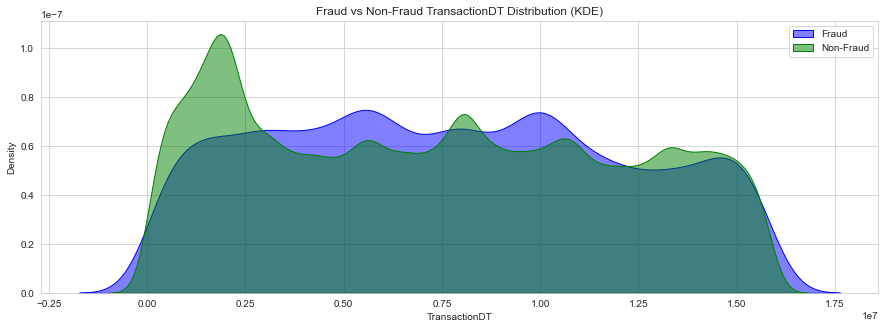

In [14]:
plt.figure(figsize=(15, 5))
sns.kdeplot(train_fraud["TransactionDT"], color='b', label='Fraud', fill=True, alpha=0.5)
sns.kdeplot(train_non_fraud["TransactionDT"], color='g', label='Non-Fraud', fill=True, alpha=0.5)
plt.title('Fraud vs Non-Fraud TransactionDT Distribution (KDE)')
plt.legend()
plt.show()


In [15]:
def multi_table(table_list):
    return HTML(
        f"<table><tr> {''.join(['<td>' + table._repr_html_() + '</td>' for table in table_list])} </tr></table>")

,Product,Fraud %,Non-Fraud %
0,C,11.687269,88.312731
1,H,4.766231,95.233769
2,R,3.782594,96.217406
3,S,5.899553,94.100447
4,W,2.039939,97.960061


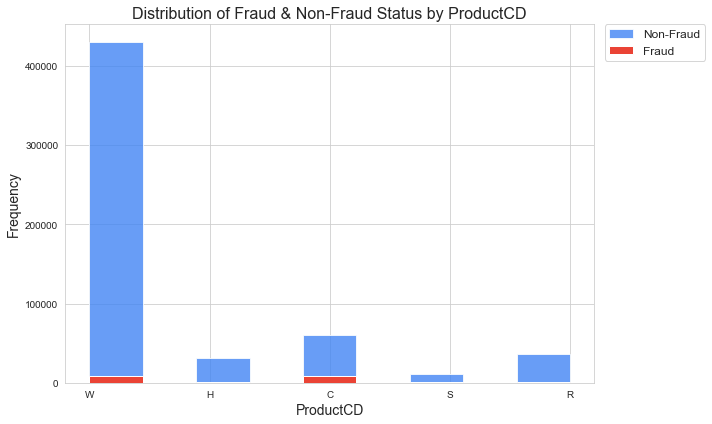

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

# Calculate the count of each category for Fraud and Non-Fraud transactions
fraud_counts = train_df[train_df["isFraud"] == 1]["ProductCD"].value_counts()
non_fraud_counts = train_df[train_df["isFraud"] == 0]["ProductCD"].value_counts()

# Calculate the total count of each category
total_counts = fraud_counts + non_fraud_counts

# Calculate the percentage of each category for Fraud and Non-Fraud transactions
fraud_percentage = (fraud_counts / total_counts) * 100
non_fraud_percentage = (non_fraud_counts / total_counts) * 100

# Create a bar plot to visualize the distribution
fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(train_df[train_df["isFraud"] == 0]["ProductCD"], bins=9, alpha=0.8, color="#4285f4", label="Non-Fraud")
ax.hist(train_df[train_df["isFraud"] == 1]["ProductCD"], bins=9, alpha=1, color="#ea4335", label="Fraud")

ax.set_xlabel("ProductCD", fontsize=14)
ax.set_ylabel("Frequency", fontsize=14)
ax.set_title("Distribution of Fraud & Non-Fraud Status by ProductCD", fontsize=16)

ax.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0., fontsize=12)
plt.tight_layout()

percentage_data = pd.DataFrame({
    "Product": fraud_percentage.index,
    "Fraud %": fraud_percentage.values,
    "Non-Fraud %": non_fraud_percentage.values
})

# Display the table using background_gradient() method directly on DataFrame
display(percentage_data.style.background_gradient(cmap='BuPu'))


It appears that certain categories have a higher likelihood of being associated with fraud, such as "C", while others, like "W," have a significantly lower likelihood of fraud. 

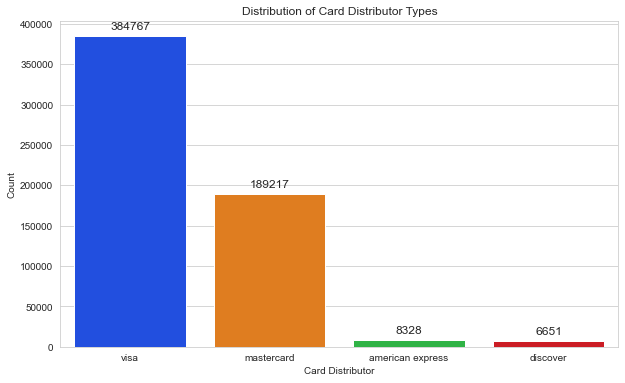

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count the occurrences of each category in the "card4" column
card_distributor = train_df['card4'].value_counts()

# Create a bar plot to visualize the distribution with a different color palette
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=card_distributor.index, y=card_distributor.values, palette='bright')

# Add count labels at the top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=12)

plt.title('Distribution of Card Distributor Types')
plt.xlabel('Card Distributor')
plt.ylabel('Count')
plt.show()


,Card Distributor,Fraud Percentage,Non-Fraud Percentage
0,Unknown,2.599873,97.400127
1,american express,2.869837,97.130163
2,discover,7.728161,92.271839
3,mastercard,3.433095,96.566905
4,visa,3.475610,96.524390


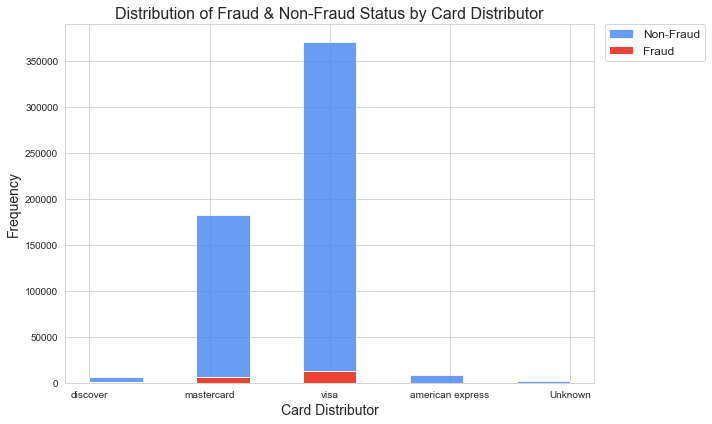

In [18]:
# Convert the "card4" column to string type and replace NaN with 'Unknown'
train_df['card4'] = train_df['card4'].astype(str).replace('nan', 'Unknown')

# Calculate the count of each category for Fraud and Non-Fraud transactions
fraud_counts = train_df[train_df["isFraud"] == 1]["card4"].value_counts()
non_fraud_counts = train_df[train_df["isFraud"] == 0]["card4"].value_counts()

# Calculate the total count of each category
total_counts = fraud_counts + non_fraud_counts

# Calculate the percentage of each category for Fraud and Non-Fraud transactions
fraud_percentage = (fraud_counts / total_counts) * 100
non_fraud_percentage = (non_fraud_counts / total_counts) * 100

# Create a bar plot to visualize the distribution
fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(train_df[train_df["isFraud"] == 0]["card4"], bins=9, alpha=0.8, color="#4285f4", label="Non-Fraud")
ax.hist(train_df[train_df["isFraud"] == 1]["card4"], bins=9, alpha=1, color="#ea4335", label="Fraud")

ax.set_xlabel("Card Distributor", fontsize=14)
ax.set_ylabel("Frequency", fontsize=14)
ax.set_title("Distribution of Fraud & Non-Fraud Status by Card Distributor", fontsize=16)

ax.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0., fontsize=12)
plt.tight_layout()

percentage_data = pd.DataFrame({
    "Card Distributor": fraud_percentage.index,
    "Fraud Percentage": fraud_percentage.values,
    "Non-Fraud Percentage": non_fraud_percentage.values
})

# Display the table using background_gradient() method directly on DataFrame
display(percentage_data.style.background_gradient(cmap='BuPu'))


The results indicate that transactions with "Discover" cards have the highest likelihood of being associated with fraud, followed by "Visa" and "Mastercard" transactions.

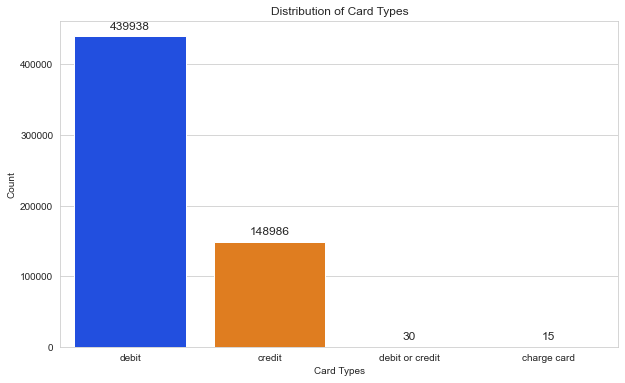

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count the occurrences of each category in the "card4" column
card_type = train_df['card6'].value_counts()

# Create a bar plot to visualize the distribution with a different color palette
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=card_type.index, y=card_type.values, palette='bright')

# Add count labels at the top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=12)

plt.title('Distribution of Card Types')
plt.xlabel('Card Types')
plt.ylabel('Count')
plt.show()


In [20]:
print('Unique count of Regions:',train_df.addr1.nunique())
print()

print('Unique count of Countries:',train_df.addr2.nunique())

Unique count of Regions: 332

Unique count of Countries: 74


In [21]:
# Calculate the count of transactions for each region
region_counts = train_df['addr1'].value_counts()

# Calculate the count of fraud transactions for each region
fraud_counts = train_df[train_df["isFraud"] == 1]['addr1'].value_counts()

# Calculate the count of non-fraud transactions for each region
non_fraud_counts = train_df[train_df["isFraud"] == 0]['addr1'].value_counts()

# Create a DataFrame with the count of transactions for each region
region_data = pd.DataFrame({
    "Region": region_counts.index,
    "Total Transactions": region_counts.values
})

# Merge the DataFrame with the count of fraud transactions for each region
region_data = pd.merge(region_data, fraud_counts, left_on="Region", right_index=True, how="left")
region_data.rename(columns={"addr1": "Fraud Transactions"}, inplace=True)

# Merge the DataFrame with the count of non-fraud transactions for each region
region_data = pd.merge(region_data, non_fraud_counts, left_on="Region", right_index=True, how="left")
region_data.rename(columns={"addr1": "Non-Fraud Transactions"}, inplace=True)

# Calculate the percentage of fraud and non-fraud transactions for each region
region_data["Fraud Percentage"] = (region_data["Fraud Transactions"] / region_data["Total Transactions"]) * 100
region_data["Non-Fraud Percentage"] = (region_data["Non-Fraud Transactions"] / region_data["Total Transactions"]) * 100

# Sort the regions based on total transaction counts in descending order
region_data = region_data.sort_values(by='Total Transactions', ascending=False)
region_data = region_data.drop(['Fraud Transactions', 'Non-Fraud Transactions'], axis=1)
# Select the top 10 regions with the highest transaction counts
top_10_regions = region_data.head(10)

display(top_10_regions.style.background_gradient(cmap='BuPu'))

,Region,Total Transactions,Fraud Percentage,Non-Fraud Percentage
0,299.000000,46335,2.125823,97.874177
1,325.000000,42751,2.542631,97.457369
2,204.000000,42020,2.665397,97.334603
3,264.000000,39870,1.825934,98.174066
4,330.000000,26287,3.195496,96.804504
5,315.000000,23078,1.780917,98.219083
6,441.000000,20827,2.559178,97.440822
7,272.000000,20141,2.859838,97.140162
8,123.000000,16105,2.471282,97.528718
9,126.000000,15243,2.532310,97.467690


In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# Calculate the count of transactions for each country
country_counts = train_df['addr2'].value_counts()

# Calculate the count of fraud transactions for each country
fraud_counts = train_df[train_df["isFraud"] == 1]['addr2'].value_counts()

# Calculate the count of non-fraud transactions for each country
non_fraud_counts = train_df[train_df["isFraud"] == 0]['addr2'].value_counts()

# Create a DataFrame with the count of transactions for each country
country_data = pd.DataFrame({
    "Country": country_counts.index,
    "Total Transactions": country_counts.values
})

# Merge the DataFrame with the count of fraud transactions for each country
country_data = pd.merge(country_data, fraud_counts, left_on="Country", right_index=True, how="left")
country_data.rename(columns={"addr2": "Fraud Transactions"}, inplace=True)

# Merge the DataFrame with the count of non-fraud transactions for each country
country_data = pd.merge(country_data, non_fraud_counts, left_on="Country", right_index=True, how="left")
country_data.rename(columns={"addr2": "Non-Fraud Transactions"}, inplace=True)

# Calculate the percentage of fraud and non-fraud transactions for each country
country_data["Fraud Percentage"] = (country_data["Fraud Transactions"] / country_data["Total Transactions"]) * 100
country_data["Non-Fraud Percentage"] = (country_data["Non-Fraud Transactions"] / country_data["Total Transactions"]) * 100

# Sort the countries based on total transaction counts in descending order
country_data = country_data.sort_values(by='Total Transactions', ascending=False)

# Select the top 10 countries with the highest transaction counts
top_5_countries = country_data.head(5)

display(top_5_countries.style.background_gradient(cmap='BuPu'))


,Country,Total Transactions,Fraud Transactions,Non-Fraud Transactions,Fraud Percentage,Non-Fraud Percentage
0,87.000000,520481,12477.000000,508004.000000,2.397206,97.602794
1,60.000000,3084,279.000000,2805.000000,9.046693,90.953307
2,96.000000,638,89.000000,549.000000,13.949843,86.050157
3,32.000000,91,6.000000,85.000000,6.593407,93.406593
4,65.000000,82,44.000000,38.000000,53.658537,46.341463


Some countries have a higher likelihood of fraudulent transactions, while others demonstrate a lower incidence of fraud.

In [23]:
print('Unique count of Email Domain:',train_transaction.P_emaildomain.nunique())

Unique count of Email Domain: 59


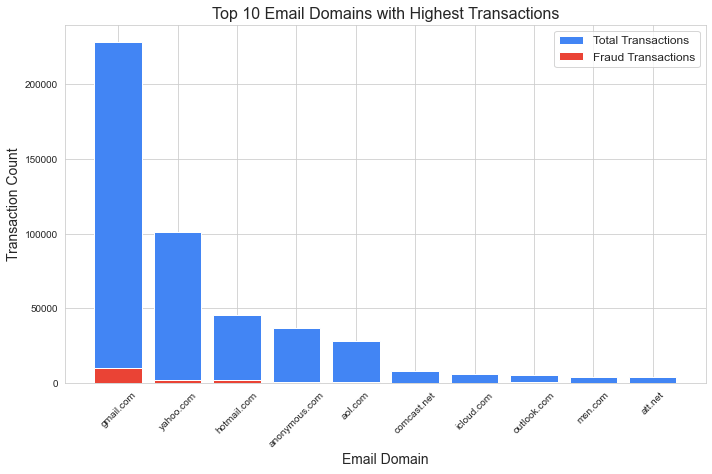

,Email Domain,Total Transactions,Fraud Transactions,Non-Fraud Transactions,Fraud Percentage,Non-Fraud Percentage
0,gmail.com,228355,9943.000000,218412,4.354185,95.645815
1,yahoo.com,100934,2297.000000,98637,2.275745,97.724255
2,hotmail.com,45250,2396.000000,42854,5.295028,94.704972
3,anonymous.com,36998,859.000000,36139,2.321747,97.678253
4,aol.com,28289,617.000000,27672,2.181060,97.818940
5,comcast.net,7888,246.000000,7642,3.118661,96.881339
6,icloud.com,6267,197.000000,6070,3.143450,96.856550
7,outlook.com,5096,482.000000,4614,9.458399,90.541601
8,msn.com,4092,90.000000,4002,2.199413,97.800587
9,att.net,4033,30.000000,4003,0.743863,99.256137


In [24]:
email_counts = train_transaction['P_emaildomain'].value_counts()
fraud_counts = train_transaction[train_transaction["isFraud"] == 1]['P_emaildomain'].value_counts()
non_fraud_counts = train_transaction[train_transaction["isFraud"] == 0]['P_emaildomain'].value_counts()

email_data = pd.DataFrame({
    "Email Domain": email_counts.index,
    "Total Transactions": email_counts.values
})

email_data = pd.merge(email_data, fraud_counts, left_on="Email Domain", right_index=True, how="left")
email_data.rename(columns={"P_emaildomain": "Fraud Transactions"}, inplace=True)
email_data = pd.merge(email_data, non_fraud_counts, left_on="Email Domain", right_index=True, how="left")
email_data.rename(columns={"P_emaildomain": "Non-Fraud Transactions"}, inplace=True)

email_data["Fraud Percentage"] = (email_data["Fraud Transactions"] / email_data["Total Transactions"]) * 100
email_data["Non-Fraud Percentage"] = (email_data["Non-Fraud Transactions"] / email_data["Total Transactions"]) * 100
email_data = email_data.sort_values(by='Total Transactions', ascending=False)

top_10_email_domains = email_data.head(10)

plt.figure(figsize=(10, 6))
plt.bar(top_10_email_domains["Email Domain"], top_10_email_domains["Total Transactions"], color="#4285f4", label="Total Transactions")
plt.bar(top_10_email_domains["Email Domain"], top_10_email_domains["Fraud Transactions"], color="#ea4335", label="Fraud Transactions")

plt.xlabel("Email Domain", fontsize=14)
plt.ylabel("Transaction Count", fontsize=14)
plt.title("Top 10 Email Domains with Highest Transactions", fontsize=16)

plt.legend(fontsize=12)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

display(top_10_email_domains.style.background_gradient(cmap='BuPu'))

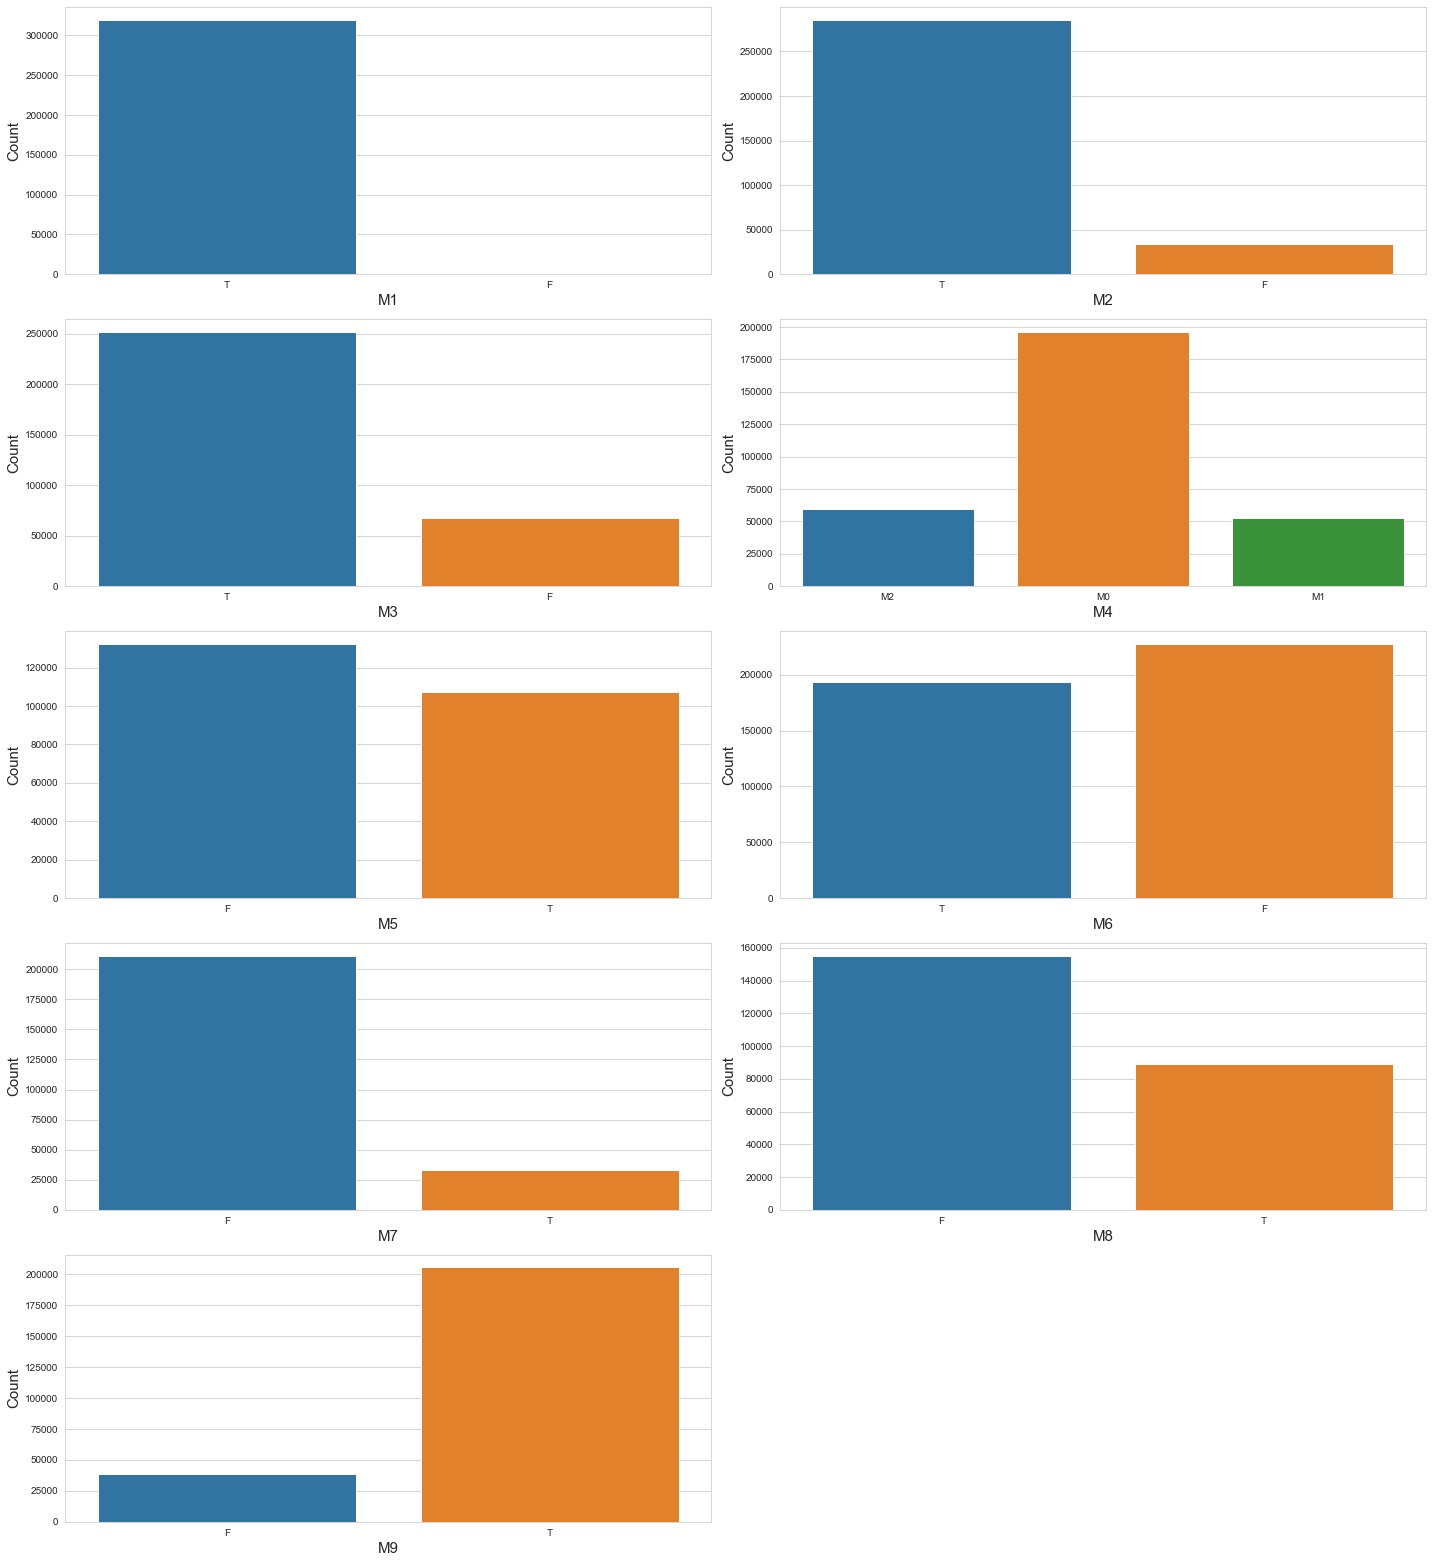

In [25]:
M_cols = ["M1", "M2", "M3", "M4", "M5", "M6", "M7", "M8", "M9"]

plt.figure(figsize=(20, 30))

for i, feature in enumerate(M_cols):
    plt.subplot(7, 2, i+1)
    sns.countplot(x=feature, data=train_df)
    plt.xticks(rotation=0)
    plt.xlabel(feature, fontsize=15)
    plt.ylabel('Count', fontsize=15)

plt.tight_layout()
plt.show()

M5, M6, M7, M8 have high false matching than true matching. These columns likely represent some kind of matching or verification process, and "false" in these columns may indicate that the match or verification was not successful or did not match the expected criteria.

In [26]:
import pandas as pd

M_cols = ["M1", "M2", "M3", "M5", "M6", "M7", "M8", "M9"]

# Create an empty list to store the tables for each column
tables = []

for feature in M_cols:
    # Convert the current column to string type and replace NaN with 'Unknown'
    train_df[feature] = train_df[feature].astype(str).replace('nan', 'Unknown')

    # Calculate the count of each category for fraud and non-fraud transactions
    fraud_counts = train_df[train_df["isFraud"] == 1][feature].value_counts()
    non_fraud_counts = train_df[train_df["isFraud"] == 0][feature].value_counts()

    # Calculate the total count of each category
    total_counts = fraud_counts + non_fraud_counts

    # Calculate the percentage of each category for fraud and non-fraud transactions
    fraud_percentage = (fraud_counts / total_counts) * 100
    non_fraud_percentage = (non_fraud_counts / total_counts) * 100

    # Create a DataFrame to store the results for the current column
    result_df = pd.DataFrame({
        "M_Category": fraud_percentage.index,
        "Fraud Percentage": fraud_percentage.values,
        "Non-Fraud Percentage": non_fraud_percentage.values
    })

    # Append the current table to the list of tables
    tables.append(result_df)

# Display the tables
for table in tables:
    display(table.style.background_gradient(cmap='BuPu'))


,M_Category,Fraud Percentage,Non-Fraud Percentage
0,F,nan,nan
1,T,1.985505,98.014495
2,Unknown,5.282553,94.717447


,M_Category,Fraud Percentage,Non-Fraud Percentage
0,F,3.485223,96.514777
1,T,1.806858,98.193142
2,Unknown,5.282553,94.717447


,M_Category,Fraud Percentage,Non-Fraud Percentage
0,Unknown,5.282553,94.717447
1,T,1.705392,98.294608
2,F,3.026186,96.973814


,M_Category,Fraud Percentage,Non-Fraud Percentage
0,F,2.652256,97.347744
1,T,3.769744,96.230256
2,Unknown,3.735998,96.264002


,M_Category,Fraud Percentage,Non-Fraud Percentage
0,F,2.368601,97.631399
1,T,1.704393,98.295607
2,Unknown,7.068375,92.931625


,M_Category,Fraud Percentage,Non-Fraud Percentage
0,Unknown,4.576264,95.423736
1,F,1.934486,98.065514
2,T,2.212699,97.787301


,M_Category,Fraud Percentage,Non-Fraud Percentage
0,Unknown,4.576436,95.423564
1,F,2.172611,97.827389
2,T,1.621798,98.378202


,M_Category,Fraud Percentage,Non-Fraud Percentage
0,Unknown,4.576436,95.423564
1,T,1.778698,98.221302
2,F,3.000104,96.999896


In [27]:
# List of columns to be renamed
columns_to_rename = ['id-01', 'id-02', 'id-03', 'id-04', 'id-05', 'id-06', 'id-07', 'id-08', 'id-09', 'id-10',
                     'id-11', 'id-12', 'id-13', 'id-14', 'id-15', 'id-16', 'id-17', 'id-18', 'id-19', 'id-20',
                     'id-21', 'id-22', 'id-23', 'id-24', 'id-25', 'id-26', 'id-27', 'id-28', 'id-29', 'id-30',
                     'id-31', 'id-32', 'id-33', 'id-34', 'id-35', 'id-36', 'id-37', 'id-38']

# Rename the columns using a custom function to replace '-' with '_'
test_df.rename(columns=lambda x: x.replace('-', '_') if x in columns_to_rename else x, inplace=True)


In [28]:
emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum', 
          'scranton.edu': 'other', 'optonline.net': 'other', 'hotmail.co.uk': 'microsoft',
          'comcast.net': 'other', 'yahoo.com.mx': 'yahoo', 'yahoo.fr': 'yahoo',
          'yahoo.es': 'yahoo', 'charter.net': 'spectrum', 'live.com': 'microsoft', 
          'aim.com': 'aol', 'hotmail.de': 'microsoft', 'centurylink.net': 'centurylink',
          'gmail.com': 'google', 'me.com': 'apple', 'earthlink.net': 'other', 'gmx.de': 'other',
          'web.de': 'other', 'cfl.rr.com': 'other', 'hotmail.com': 'microsoft', 
          'protonmail.com': 'other', 'hotmail.fr': 'microsoft', 'windstream.net': 'other', 
          'outlook.es': 'microsoft', 'yahoo.co.jp': 'yahoo', 'yahoo.de': 'yahoo',
          'servicios-ta.com': 'other', 'netzero.net': 'other', 'suddenlink.net': 'other',
          'roadrunner.com': 'other', 'sc.rr.com': 'other', 'live.fr': 'microsoft',
          'verizon.net': 'yahoo', 'msn.com': 'microsoft', 'q.com': 'centurylink', 
          'prodigy.net.mx': 'att', 'frontier.com': 'yahoo', 'anonymous.com': 'other', 
          'rocketmail.com': 'yahoo', 'sbcglobal.net': 'att', 'frontiernet.net': 'yahoo', 
          'ymail.com': 'yahoo', 'outlook.com': 'microsoft', 'mail.com': 'other', 
          'bellsouth.net': 'other', 'embarqmail.com': 'centurylink', 'cableone.net': 'other', 
          'hotmail.es': 'microsoft', 'mac.com': 'apple', 'yahoo.co.uk': 'yahoo', 'netzero.com': 'other', 
          'yahoo.com': 'yahoo', 'live.com.mx': 'microsoft', 'ptd.net': 'other', 'cox.net': 'other',
          'aol.com': 'aol', 'juno.com': 'other', 'icloud.com': 'apple'}

us_emails = ['gmail', 'net', 'edu']

# https://www.kaggle.com/c/ieee-fraud-detection/discussion/100499#latest-579654
for c in ['P_emaildomain', 'R_emaildomain']:
    train_df[c + '_bin'] = train_df[c].map(emails)
    test_df[c + '_bin'] = test_df[c].map(emails)
    
    train_df[c + '_suffix'] = train_df[c].map(lambda x: str(x).split('.')[-1])
    test_df[c + '_suffix'] = test_df[c].map(lambda x: str(x).split('.')[-1])
    
    train_df[c + '_suffix'] = train_df[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')
    test_df[c + '_suffix'] = test_df[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')

C:\Users\Jainish\AppData\Local\Temp\ipykernel_12548\3857722636.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[c + '_bin'] = test_df[c].map(emails)
C:\Users\Jainish\AppData\Local\Temp\ipykernel_12548\3857722636.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[c + '_suffix'] = test_df[c].map(lambda x: str(x).split('.')[-1])
C:\Users\Jainish\AppData\Local\Temp\ipykernel_12548\3857722636.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many tim

In [29]:
def PCA_change(df, cols, n_components, prefix='PCA_', rand_seed=4):
    pca = PCA(n_components=n_components, random_state=rand_seed)

    principalComponents = pca.fit_transform(df[cols])

    principalDf = pd.DataFrame(principalComponents)

    df.drop(cols, axis=1, inplace=True)

    principalDf.rename(columns=lambda x: str(prefix)+str(x), inplace=True)

    df = pd.concat([df, principalDf], axis=1)
    
    return df

In [30]:
test_df['isFraud'] = 'test'
df = pd.concat([train_df, test_df], axis=0, sort=False )
df = df.reset_index()
df = df.drop('index', axis=1)

C:\Users\Jainish\AppData\Local\Temp\ipykernel_12548\1876502910.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df['isFraud'] = 'test'


In [31]:
mas_v = train_df.columns[55:394]

In [32]:
from sklearn.preprocessing import minmax_scale
from sklearn.decomposition import PCA
# from sklearn.cluster import KMeans

for col in mas_v:
    df[col] = df[col].fillna((df[col].min() - 2))
    df[col] = (minmax_scale(df[col], feature_range=(0,1)))

    
df = PCA_change(df, mas_v, prefix='PCA_V_', n_components=25)

In [33]:
train_df, test_df = df[df['isFraud'] != 'test'], df[df['isFraud'] == 'test'].drop('isFraud', axis=1)

In [34]:
train_df.shape, test_df.shape

((590540, 124), (506691, 123))

In [35]:
train_df.select_dtypes(include=['object']).columns

Index(['isFraud', 'ProductCD', 'card4', 'card6', 'P_emaildomain',
       'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9',
       'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30',
       'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'DeviceType', 'DeviceInfo', 'P_emaildomain_bin', 'P_emaildomain_suffix',
       'R_emaildomain_bin', 'R_emaildomain_suffix'],
      dtype='object')

In [36]:
train_df = train_df.drop(['P_emaildomain', 'R_emaildomain'], axis=1)
test_df = test_df.drop(['P_emaildomain', 'R_emaildomain'], axis=1)
train_df['isFraud'] = train_df['isFraud'].astype(int)

In [37]:
train_df['Trans_min_mean'] = train_df['TransactionAmt'] - train_df['TransactionAmt'].mean()
train_df['Trans_min_std'] = train_df['Trans_min_mean'] / train_df['TransactionAmt'].std()
test_df['Trans_min_mean'] = test_df['TransactionAmt'] - test_df['TransactionAmt'].mean()
test_df['Trans_min_std'] = test_df['Trans_min_mean'] / test_df['TransactionAmt'].std()
train_df['TransactionAmt_to_mean_card1'] = train_df['TransactionAmt'] / train_df.groupby(['card1'])['TransactionAmt'].transform('mean')
train_df['TransactionAmt_to_mean_card4'] = train_df['TransactionAmt'] / train_df.groupby(['card4'])['TransactionAmt'].transform('mean')
train_df['TransactionAmt_to_std_card1'] = train_df['TransactionAmt'] / train_df.groupby(['card1'])['TransactionAmt'].transform('std')
train_df['TransactionAmt_to_std_card4'] = train_df['TransactionAmt'] / train_df.groupby(['card4'])['TransactionAmt'].transform('std')

test_df['TransactionAmt_to_mean_card1'] = test_df['TransactionAmt'] / test_df.groupby(['card1'])['TransactionAmt'].transform('mean')
test_df['TransactionAmt_to_mean_card4'] = test_df['TransactionAmt'] / test_df.groupby(['card4'])['TransactionAmt'].transform('mean')
test_df['TransactionAmt_to_std_card1'] = test_df['TransactionAmt'] / test_df.groupby(['card1'])['TransactionAmt'].transform('std')
test_df['TransactionAmt_to_std_card4'] = test_df['TransactionAmt'] / test_df.groupby(['card4'])['TransactionAmt'].transform('std')
train_df['TransactionAmt'] = np.log(train_df['TransactionAmt'])
test_df['TransactionAmt'] = np.log(test_df['TransactionAmt'])

In [38]:
# Calculate the percentage of null values for each column
null_percentage = (train_df.isnull().sum() / len(train_df)) * 100

# Filter columns where null percentage is greater than or equal to 60%
columns_with_60percent_null = null_percentage[null_percentage >= 50].index.tolist()

# Display the list of columns
print(columns_with_60percent_null)

['dist1', 'dist2', 'D5', 'D6', 'D7', 'D8', 'D9', 'D12', 'D13', 'D14', 'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo', 'R_emaildomain_bin', 'Trans_min_mean', 'Trans_min_std']


In [39]:
train_df.drop(columns=columns_with_60percent_null, inplace=True)
test_df.drop(columns=columns_with_60percent_null, inplace=True)

In [40]:
from sklearn import preprocessing

for f in train_df.drop('isFraud', axis=1).columns:
    if train_df[f].dtype=='object' or test_df[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train_df[f].values) + list(test_df[f].values))
        train_df[f] = lbl.transform(list(train_df[f].values))
        test_df[f] = lbl.transform(list(test_df[f].values))  

In [41]:
train_df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,PCA_V_19,PCA_V_20,PCA_V_21,PCA_V_22,PCA_V_23,PCA_V_24,TransactionAmt_to_mean_card1,TransactionAmt_to_mean_card4,TransactionAmt_to_std_card1,TransactionAmt_to_std_card4
0,2987000,0,86400,4.226562,4,13926,NaN,150.0,2,142.0,...,-0.001221,0.014740,-0.013217,0.004673,-0.049388,-0.037124,0.194580,0.257812,0.184560,0.170241
1,2987001,0,86401,3.367188,4,2755,404.0,150.0,3,102.0,...,0.001941,0.011030,-0.004106,-0.001383,0.017648,0.033836,0.123779,0.219116,0.063004,0.114214
2,2987002,0,86469,4.078125,4,4663,490.0,150.0,5,166.0,...,0.003851,-0.005303,-0.002080,-0.006052,-0.001878,-0.000841,0.608398,0.443115,0.589226,0.258550
3,2987003,0,86499,3.912109,4,18132,567.0,150.0,3,117.0,...,0.024842,0.014989,0.024080,-0.000953,0.032882,0.056480,0.405029,0.377686,0.259460,0.196921
4,2987004,0,86506,3.912109,1,4497,514.0,150.0,3,102.0,...,-0.011893,0.013114,0.069845,0.024059,0.017224,-0.045266,0.515625,0.377686,0.882898,0.196921


In [42]:
X_train = train_df.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT', 'TransactionID'], axis=1)
y_train = train_df.sort_values('TransactionDT')['isFraud'].astype(bool)

X_test = test_df.sort_values('TransactionDT').drop(['TransactionDT','TransactionID'], axis=1)
#test_df = test_df[["TransactionDT"]]

In [55]:
# Import necessary libraries
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import roc_auc_score, make_scorer
from hyperopt import fmin, tpe, hp
import time
from xgboost import XGBClassifier

# Load your data (X_train, y_train) here

# Define the objective function for hyperparameter tuning
def optimize_hyperparameters(params):
    # Initialize time
    time_start = time.time()
    
    # Format hyperparameters
    max_depth = int(params['max_depth'])
    gamma = params['gamma']
    subsample = params['subsample']
    reg_alpha = params['reg_alpha']
    reg_lambda = params['reg_lambda']
    learning_rate = params['learning_rate']
    num_leaves = params['num_leaves']
    colsample_bytree = params['colsample_bytree']
    min_child_samples = params['min_child_samples']
    feature_fraction = params['feature_fraction']
    bagging_fraction = params['bagging_fraction']

    print("\n############## New Run ################")
    print(f"Hyperparameters: {params}")
    
    # Set up TimeSeriesSplit for cross-validation
    num_splits = 3  # Reduced the number of folds
    tss = TimeSeriesSplit(n_splits=num_splits)
    
    total_score = 0
    
    # Loop through cross-validation folds
    for fold_idx, (train_idx, val_idx) in enumerate(tss.split(X_train, y_train)):
        # Create XGBoost classifier with specified hyperparameters
        clf = XGBClassifier(
            n_estimators=200, random_state=4, verbose=True, 
            tree_method='hist',  # Use CPU for computation
            max_depth=max_depth,
            gamma=gamma,
            subsample=subsample,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            learning_rate=learning_rate,
            num_leaves=num_leaves,
            colsample_bytree=colsample_bytree,
            min_child_samples=min_child_samples,
            feature_fraction=feature_fraction,
            bagging_fraction=bagging_fraction
        )

        # Prepare train and validation data
        X_tr, X_vl = X_train.iloc[train_idx, :], X_train.iloc[val_idx, :]
        y_tr, y_vl = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        # Train the model
        clf.fit(X_tr, y_tr)
        
        # Evaluate the model using ROC AUC score
        score = make_scorer(roc_auc_score, needs_proba=True)(clf, X_vl, y_vl)
        total_score += score
        
        # Print fold information
        print(f'Fold {fold_idx + 1} - ROC AUC: {round(score, 4)}')
    
    # Calculate mean ROC AUC score
    mean_score = total_score / num_splits
    
    # Calculate total time and print
    time_elapsed = (time.time() - time_start) / 60
    print(f"Total Time Elapsed: {round(time_elapsed, 2)} minutes")
    print(f'Mean ROC AUC: {mean_score}')
    
    return -mean_score

# Define the hyperparameter search space
hyperparameter_space = {
    'max_depth': hp.quniform('max_depth', 7, 15, 1),  # Reduced the range
    'reg_alpha': hp.uniform('reg_alpha', 0.01, 0.2),  # Reduced the range
    'reg_lambda': hp.uniform('reg_lambda', 0.01, 0.2),  # Reduced the range
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.1),  # Reduced the range
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 0.8),  # Reduced the range
    'gamma': hp.uniform('gamma', 0.01, 0.3),  # Reduced the range
    'num_leaves': hp.choice('num_leaves', list(range(20, 100, 10))),  # Reduced the range
    'min_child_samples': hp.choice('min_child_samples', list(range(100, 200, 20))),  # Reduced the range
    'subsample': hp.choice('subsample', [0.4, 0.6, 0.8]),  # Reduced the options
    'feature_fraction': hp.uniform('feature_fraction', 0.4, 0.7),  # Reduced the range
    'bagging_fraction': hp.uniform('bagging_fraction', 0.4, 0.7)  # Reduced the range
}

# Perform hyperparameter tuning using Bayesian optimization
best_hyperparameters = fmin(fn=optimize_hyperparameters, space=hyperparameter_space, algo=tpe.suggest, max_evals=5)  # Reduced the max_evals


                                                     
############## New Run ################
Hyperparameters: {'bagging_fraction': 0.6975564059878252, 'colsample_bytree': 0.7445971000215363, 'feature_fraction': 0.6742275680642895, 'gamma': 0.14166749372386261, 'learning_rate': 0.010386994027198084, 'max_depth': 9.0, 'min_child_samples': 140, 'num_leaves': 20, 'reg_alpha': 0.14092052399913996, 'reg_lambda': 0.0784054695932606, 'subsample': 0.6}
[20:10:02] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "bagging_fraction", "feature_fraction", "min_child_samples", "num_leaves", "verbose" } are not used.

Fold 1 - ROC AUC: 0.8713                             
[20:10:22] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "bagging_fraction", "feature_fraction", "min_child_samp

Total Time Elapsed: 2.1 minutes                                                  
Mean ROC AUC: 0.8987874459887885                                                 
100%|██████████| 5/5 [09:45<00:00, 117.19s/trial, best loss: -0.9026680186454111]


In [56]:
print("Best Hyperparameters:")
print(best_hyperparameters)

Best Hyperparameters:
{'bagging_fraction': 0.5443288556061796, 'colsample_bytree': 0.6322197408979047, 'feature_fraction': 0.6681592145711508, 'gamma': 0.29064554288107014, 'learning_rate': 0.047415993656891565, 'max_depth': 12.0, 'min_child_samples': 1, 'num_leaves': 5, 'reg_alpha': 0.15697948660451608, 'reg_lambda': 0.017295718452895018, 'subsample': 2}


In [60]:
best_clf = xgb.XGBClassifier(
    n_estimators=600, random_state=4, verbose=True, 
    tree_method='hist',  
    max_depth=12,
    gamma=0.29064554288107014,
    subsample=0.2,
    reg_alpha=0.15697948660451608,
    reg_lambda=0.017295718452895018,
    learning_rate=0.047415993656891565,
    num_leaves=5,
    colsample_bytree=0.6322197408979047,
    min_child_samples=1,
    feature_fraction=0.6681592145711508,
    bagging_fraction=0.5443288556061796
)

best_clf.fit(X_train, y_train)
#y_pred = best_clf.predict(X_test)
y_preds = best_clf.predict_proba(X_test)[:,1] 

[21:27:39] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "bagging_fraction", "feature_fraction", "min_child_samples", "num_leaves", "verbose" } are not used.



In [61]:
feature_importance = best_clf.get_booster().get_score(importance_type="weight")

# Convert feature importance to a DataFrame
keys = list(feature_importance.keys())
values = list(feature_importance.values())
data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by="score", ascending=False)

# Display the top 20 most important features
top_20_features = data.head(20)
print(top_20_features)

                                score
TransactionAmt_to_std_card1   11221.0
card1                         10898.0
TransactionAmt_to_mean_card1   9571.0
card2                          9164.0
addr1                          8189.0
TransactionAmt_to_std_card4    5995.0
TransactionAmt_to_mean_card4   5579.0
TransactionAmt                 5362.0
PCA_V_17                       5046.0
PCA_V_13                       4807.0
PCA_V_23                       4746.0
PCA_V_16                       4681.0
PCA_V_24                       4588.0
PCA_V_20                       4587.0
PCA_V_12                       4574.0
PCA_V_19                       4537.0
PCA_V_22                       4523.0
PCA_V_15                       4447.0
PCA_V_14                       4416.0
PCA_V_11                       4399.0


Transaction Amount Related Features: Features like TransactionAmt_to_std_card1, TransactionAmt_to_mean_card1, TransactionAmt_to_std_card4, and TransactionAmt_to_mean_card4 have high importance scores. This suggests that the relationship between transaction amounts and certain card-related attributes (like card1 and card4) is crucial for identifying fraudulent transactions.

Card and Address Information: Features such as card1, card2, and addr1 are among the most important. This indicates that specific cards and addresses play a significant role in detecting fraud. It's possible that fraudulent transactions might exhibit certain patterns in card and address usage.

Principal Components (PCA): Features like PCA_V_17, PCA_V_13, PCA_V_23, etc., are principal components derived from the data using PCA. The fact that these components have high importance suggests that certain combinations of original features, captured through PCA, are strong indicators of fraud.

Transaction Amount (TransactionAmt): The raw transaction amount itself (TransactionAmt) is also an important feature. This could indicate that unusually high or low transaction amounts might be indicative of fraud.